In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from mpl_toolkits.mplot3d import Axes3D


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
df = pd.read_json("../scripts/Metropolis_CVE.json")

In [3]:
mpos_folder = 'mpos_2020'

In [4]:
for c in df.columns.unique():
        if c == 'Guadalajara':
            mun_gdf = gpd.GeoDataFrame()
            for i in range(len(df.loc["mpos", c])):
                # Extracts specific municipality code
                m = df.loc["mpos", c][i]
                # Downloads municipality polygon according to code
                query = f"SELECT * FROM marco.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
                mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [5]:
mun_gdf = mun_gdf.set_crs("EPSG:4326")

<AxesSubplot:>

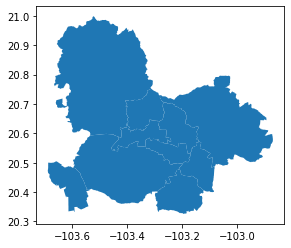

In [6]:
mun_gdf.plot()

In [7]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

In [8]:
grl_path = '../data/external/MDE/'
mde_path = [] # list to append mde path strings
c='Guadalajara'
#Gathers state codes for MDE
for i in range(len(df.loc["edo", c])):
    e = df.loc["edo", c][i]
    tmp_path = grl_path + (f'CEM_V3_20170619_R15_E{e}_TIF/')

    #search for files in tmp_path for .tif
    for f in os.listdir(tmp_path):
        if f.endswith('.tif'):
            mde_path.append(tmp_path+f)

In [9]:
mde_path

['../data/external/MDE/CEM_V3_20170619_R15_E14_TIF/Jalisco_r15m.tif']

In [10]:
nodes_tmp = nodes.reset_index().copy()

edges_tmp = edges.reset_index().copy()

from_osmid = list(set(edges_tmp['u'].to_list()).difference(set(nodes_tmp.osmid.to_list())))

nodes_dict = nodes_tmp.to_dict()

for i in from_osmid:
    row = edges_tmp.loc[(edges_tmp.u==i)].iloc[0]
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    
    nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
    nodes_dict['x'][len(nodes_dict['x'])] = first_coord[0]
    nodes_dict['y'][len(nodes_dict['y'])] = first_coord[1]
    nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
    nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(first_coord)
        
    
to_osmid = list(set(edges_tmp['v'].to_list()).difference(set(list(nodes_dict['osmid'].values()))))

for i in to_osmid:
    row = edges_tmp.loc[(edges_tmp.u==i)].iloc[0]
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    
    nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
    nodes_dict['x'][len(nodes_dict['x'])] = last_coord[0]
    nodes_dict['y'][len(nodes_dict['y'])] = last_coord[1]
    nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
    nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(last_coord)
    
nodes_tmp = pd.DataFrame.from_dict(nodes_dict)
nodes_tmp = gpd.GeoDataFrame(nodes_tmp, crs="EPSG:4326", geometry='geometry')

In [11]:
nodes_tmp

,osmid,x,y,street_count,geometry
0,28751344,-103.306309,20.711533,3.0,POINT (-103.30631 20.71153)
1,28753224,-103.316645,20.700650,3.0,POINT (-103.31665 20.70065)
2,28757751,-103.307356,20.708526,3.0,POINT (-103.30736 20.70853)
3,28757777,-103.306806,20.710093,4.0,POINT (-103.30681 20.71009)
4,28768905,-103.305728,20.696546,3.0,POINT (-103.30573 20.69655)
...,...,...,...,...,...
173959,8404816004,-103.408646,20.544511,NaN,POINT (-103.40865 20.54451)
173960,8389432427,-103.473608,20.539874,NaN,POINT (-103.47361 20.53987)
173961,1776712044,-103.420512,20.546057,NaN,POINT (-103.42051 20.54606)
173962,6289765594,-103.406357,20.543847,NaN,POINT (-103.40636 20.54385)


In [12]:
G_new = ox.graph_from_gdfs(nodes_tmp.set_index('osmid'), edges_tmp.set_index(['u','v','key']))

In [13]:
G_elev_mde = ox.elevation.add_node_elevations_raster(G_new, mde_path)

In [14]:
G_elev_mde = ox.elevation.add_edge_grades(G_elev_mde, add_absolute=True, precision=3)

In [15]:
nodes_elev_mde, edges_elev_mde = ox.graph_to_gdfs(G_elev_mde, nodes=True, edges=True)

In [16]:
print(nodes_elev_mde.shape)
nodes_elev_mde.head(4)

(173964, 5)


,x,y,street_count,elevation,geometry
osmid,,,,,
1754406771,-103.402106,20.500385,3.0,1550.0,POINT (-103.40211 20.50038)
1754406780,-103.400626,20.500664,3.0,1547.0,POINT (-103.40063 20.50066)
1754406772,-103.397833,20.500383,4.0,1539.0,POINT (-103.39783 20.50038)
1754406789,-103.398871,20.500910,3.0,1540.0,POINT (-103.39887 20.50091)


In [17]:
print(edges_elev_mde.shape)
edges_elev_mde.head(4)

(419221, 17)


osmid  oneway                    name  \
u          v          key                                              
1754406771 1754406780 0    163760869   False  Calle Cumbre del Marco   
           1754406763 0    163760852   False    Calle Cumbre Córdoba   
           6459500675 0    163760852   False    Calle Cumbre Córdoba   
1754406780 1754406771 0    163760869   False  Calle Cumbre del Marco   

                               highway   length  \
u          v          key                         
1754406771 1754406780 0    residential  157.211   
           1754406763 0    residential   41.093   
           6459500675 0    residential    4.747   
1754406780 1754406771 0    residential  157.211   

                                                                    geometry  \
u          v          key                                                      
1754406771 1754406780 0    LINESTRING (-103.40211 20.50038, -103.40063 20...   
           1754406763 0    LINESTRING (-103.40211 20.50038, -103.40220 20...   
           6459500675 0    LINESTRING (-103.40211 20.50038, -103.40209 20...   
1754406780 1754406771 0    LINESTRING (-103.40063 20.50066, -103.40211 20...   

                           grade  grade_abs junction maxspeed  ref bridge  \
u          v          key                                                   
1754406771 1754406780 0   -0.019      0.019      NaN      NaN  NaN    NaN   
           1754406763 0   -0.024      0.024      NaN      NaN  NaN    NaN   
           6459500675 0    0.000      0.000      NaN      NaN  NaN    NaN   
1754406780 1754406771 0    0.019      0.019      NaN      NaN  NaN    NaN   

                          lanes access tunnel width service  
u          v          key                                    
1754406771 1754406780 0     NaN    NaN    NaN   NaN     NaN  
           1754406763 0     NaN    NaN    NaN   NaN     NaN  
           6459500675 0     NaN    NaN    NaN   NaN     NaN  
1754406780 1754406771 0     NaN    NaN    NaN   NaN     NaN

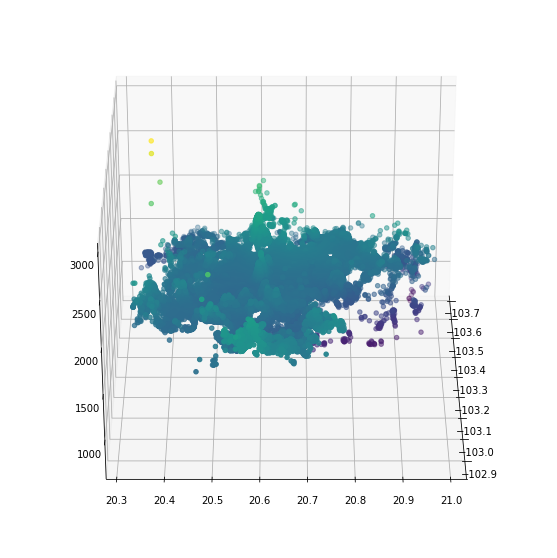

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

xs = nodes_elev_mde.geometry.x
ys = nodes_elev_mde.geometry.y
zs = nodes_elev_mde.elevation

ax.view_init(30, 360)

ax.scatter(xs, ys, zs, c=zs)

<AxesSubplot:>

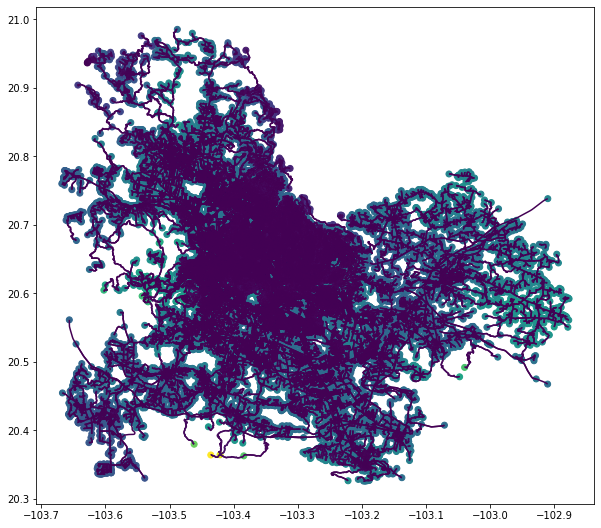

In [19]:
fig = plt.figure(figsize=(10,10))

ax = fig.gca()


edges_elev_mde.plot(column='grade_abs', ax=ax)
nodes_elev_mde.plot(column='elevation', ax=ax)

<AxesSubplot:>

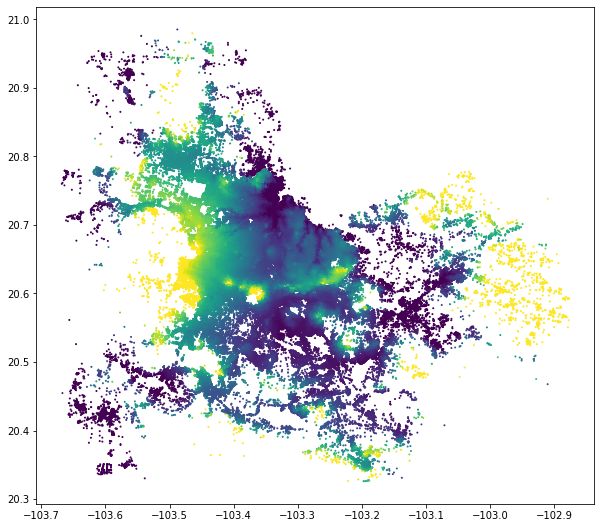

In [23]:
fig = plt.figure(figsize=(10,10))

ax = fig.gca()

nodes_elev_mde.plot(column='elevation', s=1, vmin=1500, vmax=1700, ax=ax)

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.gca(projection='3d')

surf = ax.plot_trisurf(xs, ys, zs, cmap='viridis',
                       linewidth=0, antialiased=False)

ax.view_init(30, 360)

plt.show()